In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import matplotlib as plt
import time

from model import CustomResNet, ConvBlock
from torchvision.models.resnet import BasicBlock, Bottleneck

from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.transforms import ToTensor, Compose, RandomCrop, RandomHorizontalFlip, Normalize
from torch.utils.data import DataLoader, random_split
from torch.optim import SGD, lr_scheduler
from tqdm import tqdm

dataset_name = 'cifar100'
teacher_name = 'resnet56_baseline'
student_name = 'resnet56_recast'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_class = 100
batch_size = 64
epoch = 60
lr = 0.001
step_size = 20

mse_loss = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

In [10]:
transform = Compose([
    ToTensor(),
    RandomCrop(size=[32, 32], padding=4),
    RandomHorizontalFlip(p=0.5),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

transform_test = Compose([
    ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR100(root='./data', train=False, transform=transform_test, download=True)

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터셋 확인
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(test_dataset)}')

Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 50000
Validation dataset size: 10000


In [11]:
teacher = CustomResNet(block=BasicBlock,
                   layers=[9, 9, 9],
                   num_classes=num_class).to(device).eval()
checkpoint = torch.load(f'./result/{dataset_name}_{teacher_name}.pt')
teacher.load_state_dict(checkpoint['model'])

total_params = sum(p.numel() for p in teacher.parameters())
print(f'Total number of parameters: {total_params}')
print(teacher)

Total number of parameters: 861620
CustomResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3),

In [12]:
student = CustomResNet(block=BasicBlock,
                   layers=[9, 9, 9],
                   num_classes=num_class).to(device)
checkpoint = torch.load(f'./result/{dataset_name}_{teacher_name}.pt')
student.load_state_dict(checkpoint['model'])

total_params = sum(p.numel() for p in student.parameters())
print(f'Total number of parameters: {total_params}')
print(student)

Total number of parameters: 861620
CustomResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3),

In [13]:
history = dict()
for idx in range(len(student.layers)):
    history[idx] = dict(train_loss=[], test_acc=[], train_time=[], test_time=[])
    
    # recasting
    print(f'block {idx} recasting...')
    target_block = student.layers[idx]
    in_channels = target_block.conv1.in_channels
    stride = target_block.conv1.stride
    out_channels = target_block.conv2.out_channels
    
    student.layers[idx] = ConvBlock(in_channels, out_channels, stride).to(device)
    for m in student.layers[idx].modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    params = []
    for i in range(idx + 1):
        params.extend(student.layers[i].parameters())
    optimizer = torch.optim.Adam(params, lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size)

    print(f'block {idx} training started...')
    for ep in range(epoch):
        # train step
        train_loss = 0.0
        student.train()
        s_time = time.time()
        for i, (image, _) in enumerate(train_loader):
            image = image.to(device)

            target = teacher(image, idx)
            pred = student(image, idx)

            loss = mse_loss(pred, target)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        e_time = time.time()
        history[idx]['train_loss'].append(train_loss/len(train_loader))
        history[idx]['train_time'].append(e_time - s_time)

        # test step
        test_acc = 0.0
        student.eval()
        s_time = time.time()
        for image, target in test_loader:
            image = image.to(device)
            target = f.one_hot(target, num_class).float().to(device)

            pred = student(image)
            test_acc += torch.sum(torch.argmax(pred, dim=1) == torch.argmax(target, dim=1)).item()
        e_time = time.time()
        history[idx]['test_acc'].append(test_acc/len(test_dataset))
        history[idx]['test_time'].append(e_time - s_time)
        print(f'epoch={ep:d}, train_loss={train_loss/len(train_loader):.4f}, test_acc={test_acc/len(test_dataset):.4f}')

        checkpoint = dict(
            model=student.state_dict(),
            optimizer=optimizer.state_dict(),
            history=history,
            epoch=ep
        )
        torch.save(checkpoint, f'./result/{dataset_name}_{student_name}.pt')
        scheduler.step()

block 0 recasting...
block 0 training started...
epoch=0, train_loss=0.5370, test_acc=0.5458
epoch=1, train_loss=0.1971, test_acc=0.6577
epoch=2, train_loss=0.0829, test_acc=0.6718
epoch=3, train_loss=0.0492, test_acc=0.6759
epoch=4, train_loss=0.0411, test_acc=0.6702
epoch=5, train_loss=0.0320, test_acc=0.6748
epoch=6, train_loss=0.0253, test_acc=0.6864
epoch=7, train_loss=0.0209, test_acc=0.6917
epoch=8, train_loss=0.0191, test_acc=0.6925
epoch=9, train_loss=0.0190, test_acc=0.6910
epoch=10, train_loss=0.0186, test_acc=0.6929
epoch=11, train_loss=0.0185, test_acc=0.6940
epoch=12, train_loss=0.0185, test_acc=0.6937
epoch=13, train_loss=0.0185, test_acc=0.6940
epoch=14, train_loss=0.0184, test_acc=0.6941
epoch=15, train_loss=0.0184, test_acc=0.6940
epoch=16, train_loss=0.0183, test_acc=0.6938
epoch=17, train_loss=0.0183, test_acc=0.6959
epoch=18, train_loss=0.0183, test_acc=0.6945
epoch=19, train_loss=0.0182, test_acc=0.6951
epoch=20, train_loss=0.0182, test_acc=0.6940
epoch=21, train_

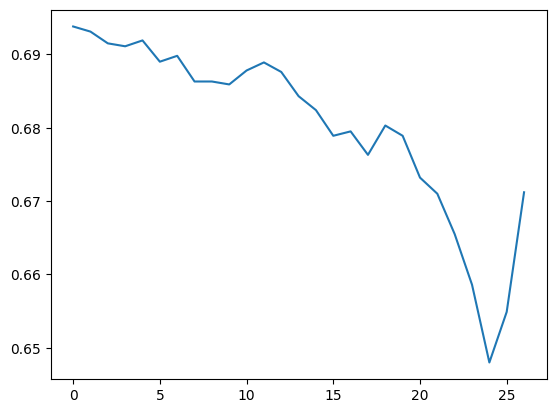

In [13]:
import matplotlib.pyplot as plt
import numpy as np

student = CustomResNet(block=ConvBlock,
                   layers=[9, 9, 9],
                   num_classes=num_class).to(device)
checkpoint = torch.load(f'./result/{dataset_name}_{student_name}.pt')
student.load_state_dict(checkpoint['model'])

total_params = sum(p.numel() for p in student.parameters())
print(f'Total number of parameters: {total_params}')
print(student)

checkpoint['history'][0]['test_acc']

x = np.arange(len(checkpoint['history']))
y = list(checkpoint['history'][i]['test_acc'][-1] for i in range(len(checkpoint['history'])))

plt.plot(x, y)